#### Copyright 2017 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
# Cell 1 — Setup: install packages (if needed) and show environment info
!pip install openpyxl --quiet

import sys
print("Python", sys.version)
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline



Python 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]


In [2]:
# Cell 2 — (Optional) Mount Google Drive to save outputs
from google.colab import drive
drive.mount('online_retail_II.csv')   # follow the prompts
# Example save path: /content/drive/MyDrive/online_retail/


Mounted at online_retail_II.csv


In [3]:
# Cell 3 — Download the UCI Online Retail Excel file (will save to /content)
# UCI file: Online Retail.xlsx
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
local_path = "/content/Online_Retail.xlsx"

# Download (works in Colab)
import urllib.request
print("Downloading dataset...")
urllib.request.urlretrieve(dataset_url, local_path)
print("Saved to", local_path)

# Note: file source = UCI ML Repository. :contentReference[oaicite:1]{index=1}


Saved to /content/Online_Retail.xlsx


In [4]:
# Cell 4 — Load into pandas (it's an Excel file)
df = pd.read_excel(local_path, engine='openpyxl')
print("Rows, columns:", df.shape)
df.head(5)


Rows, columns: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# Cell 5 — Quick data inspection
df.info()
df.describe(include='all').T
print("Missing values per column:")
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
Missing values per column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


KeyError: 'invoice_date'

In [7]:
# Cell 6 — Basic cleaning steps (keep a copy of original)
df_clean = df.copy()

# 1) Rename columns to snake_case for convenience
df_clean.columns = [c.strip().lower().replace(' ', '_') for c in df_clean.columns]

# 2) Parse invoice date if not already parsed
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# 3) Remove rows with no invoice or no stockcode (optional)
df_clean = df_clean[df_clean['InvoiceNo'].notna()]

# 4) Convert numeric columns
df_clean['Quantity'] = pd.to_numeric(df_clean['Quantity'], errors='coerce')
df_clean['UnitPrice'] = pd.to_numeric(df_clean['UnitPrice'], errors='coerce')

# 5) Remove cancelled transactions (InvoiceNo starting with 'C')
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]

# 6) Create line_total (quantity * unit_price)
df_clean['line_total'] = df_clean['Quantity'] * df_clean['UnitPrice']

# 7) Drop rows with missing customer id if you plan customer-level analysis (optional)
# df_clean = df_clean[df_clean['customer_id'].notna()]

print("After cleaning:", df_clean.shape)
df_clean.head(3)


KeyError: 'InvoiceDate'

In [8]:
df.columns = df.columns.str.strip()   # remove leading/trailing spaces
df.columns = df.columns.str.lower()   # make lowercase for consistency
print(df.columns.tolist())


['invoiceno', 'stockcode', 'description', 'quantity', 'invoicedate', 'unitprice', 'customerid', 'country']


In [9]:
# Cell 6 — Basic cleaning steps (keep a copy of original)
df_clean = df.copy()

# 1) Rename columns to snake_case for convenience
df_clean.columns = [c.strip().lower().replace(' ', '_') for c in df_clean.columns]

# 2) Parse invoice date if not already parsed
df_clean['invoicedate'] = pd.to_datetime(df_clean['invoicedate'])

# 3) Remove rows with no invoice or no stockcode (optional)
df_clean = df_clean[df_clean['invoiceno'].notna()]

# 4) Convert numeric columns
df_clean['quantity'] = pd.to_numeric(df_clean['quantity'], errors='coerce')
df_clean['unitprice'] = pd.to_numeric(df_clean['unitprice'], errors='coerce')

# 5) Remove cancelled transactions (InvoiceNo starting with 'C')
df_clean = df_clean[~df_clean['invoiceno'].astype(str).str.startswith('C')]

# 6) Create line_total (quantity * unit_price)
df_clean['line_total'] = df_clean['quantity'] * df_clean['unitprice']

# 7) Drop rows with missing customer id if you plan customer-level analysis (optional)
# df_clean = df_clean[df_clean['customer_id'].notna()]

print("After cleaning:", df_clean.shape)
df_clean.head(3)


After cleaning: (532621, 9)


,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,line_total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00


In [10]:
# Cell 7 — Example exploratory checks
# Top countries
print(df_clean['country'].value_counts().head(10))

# Top products by revenue
top_products = (df_clean.groupby('description')
                .agg(revenue=('line_total','sum'), quantity=('quantity','sum'))
                .sort_values('revenue', ascending=False)
                .head(10))
top_products


country
United Kingdom    487622
Germany             9042
France              8408
EIRE                7894
Spain               2485
Netherlands         2363
Belgium             2031
Switzerland         1967
Portugal            1501
Australia           1185
Name: count, dtype: int64


,revenue,quantity
description,,
DOTCOM POSTAGE,206248.77,708
REGENCY CAKESTAND 3 TIER,174484.74,13890
"PAPER CRAFT , LITTLE BIRDIE",168469.60,80995
WHITE HANGING HEART T-LIGHT HOLDER,106292.77,37895
PARTY BUNTING,99504.33,18299
JUMBO BAG RED RETROSPOT,94340.05,48478
MEDIUM CERAMIC TOP STORAGE JAR,81700.92,78033
Manual,78112.82,7231
POSTAGE,78101.88,3150


In [11]:
# Cell 8 — Monthly aggregation using pandas: order_count (invoices) & revenue
df_clean['year'] = df_clean['invoicedate'].dt.year
df_clean['month'] = df_clean['invoicedate'].dt.month

monthly = (df_clean
           .groupby(['year','month'])
           .agg(order_count=('invoiceno','nunique'),
                total_revenue=('line_total','sum'),
                total_quantity=('quantity','sum'))
           .reset_index()
           .sort_values(['year','month'])
          )
monthly['ym'] = monthly['year'].astype(str) + '-' + monthly['month'].astype(str).str.zfill(2)
monthly


,year,month,order_count,total_revenue,total_quantity,ym
0,2010,12,1699,823746.140,358270,2010-12
1,2011,1,1216,691364.560,388811,2011-01
2,2011,2,1174,523631.890,280860,2011-02
3,2011,3,1665,717639.360,357267,2011-03
4,2011,4,1504,537808.621,302743,2011-04
5,2011,5,1848,770536.020,386259,2011-05
6,2011,6,1683,761739.900,348985,2011-06
7,2011,7,1657,719221.191,397144,2011-07
8,2011,8,1459,737014.260,418545,2011-08
9,2011,9,1994,1058590.172,557246,2011-09


from matplotlib import pyplot as plt
monthly['year'].plot(kind='hist', bins=20, title='year')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
monthly['month'].plot(kind='hist', bins=20, title='month')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
monthly['order_count'].plot(kind='hist', bins=20, title='order_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
monthly['total_revenue'].plot(kind='hist', bins=20, title='total_revenue')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
monthly.plot(kind='scatter', x='year', y='month', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
monthly.plot(kind='scatter', x='month', y='order_count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
monthly.plot(kind='scatter', x='order_count', y='total_revenue', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
monthly.plot(kind='scatter', x='total_revenue', y='total_quantity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['year']
  ys = series['month']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = monthly.sort_values('year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('month')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['year']
  ys = series['order_count']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = monthly.sort_values('year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('order_count')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['year']
  ys = series['total_revenue']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = monthly.sort_values('year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('total_revenue')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['year']
  ys = series['total_quantity']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = monthly.sort_values('year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('total_quantity')

from matplotlib import pyplot as plt
monthly['year'].plot(kind='line', figsize=(8, 4), title='year')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
monthly['month'].plot(kind='line', figsize=(8, 4), title='month')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
monthly['order_count'].plot(kind='line', figsize=(8, 4), title='order_count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
monthly['total_revenue'].plot(kind='line', figsize=(8, 4), title='total_revenue')
plt.gca().spines[['top', 'right']].set_visible(False)

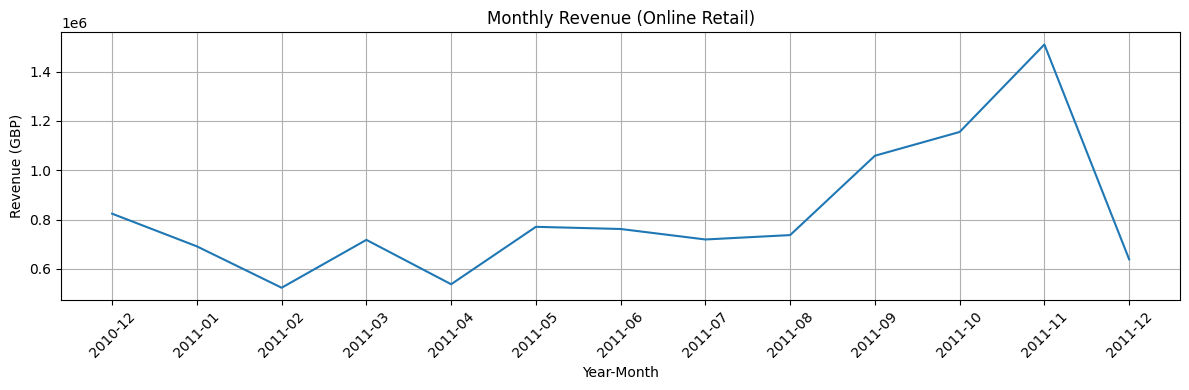

In [12]:
# Cell 9 — Plot monthly revenue (matplotlib)
plt.figure(figsize=(12,4))
plt.plot(monthly['ym'], monthly['total_revenue'])
plt.xticks(rotation=45)
plt.title('Monthly Revenue (Online Retail)')
plt.xlabel('Year-Month')
plt.ylabel('Revenue (GBP)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
# Cell 10 — Save aggregated output CSV to local or Drive
monthly.to_csv('/content/monthly_summary.csv', index=False)
print("Saved /content/monthly_summary.csv")
# If Drive mounted, also copy to Drive (uncomment if desired)
# monthly.to_csv('/content/drive/MyDrive/online_retail/monthly_summary.csv', index=False)


Saved /content/monthly_summary.csv


In [15]:
# Cell 11 — Optional: create a SQLite DB from the cleaned DataFrame and run example SQL
db_path = "/content/online_retail.db"
conn = sqlite3.connect(db_path)
df_clean.to_sql('orders', conn, if_exists='replace', index=False)
print("SQLite DB saved to", db_path)

# Example SQL: monthly revenue using SQLite strftime
sql = """
SELECT
  strftime('%Y', invoicedate) AS year,
  strftime('%m', invoicedate) AS month,
  COUNT(DISTINCT invoiceno) AS order_count,
  SUM(line_total) AS total_revenue
FROM orders
GROUP BY year, month
ORDER BY year, month;
"""
monthly_sql = pd.read_sql(sql, conn)
monthly_sql.head()


SQLite DB saved to /content/online_retail.db


,year,month,order_count,total_revenue
0,2010,12,1699,823746.140
1,2011,01,1216,691364.560
2,2011,02,1174,523631.890
3,2011,03,1665,717639.360
4,2011,04,1504,537808.621


# Intro to pandas

**Learning Objectives:**
  * Gain an introduction to the `DataFrame` and `Series` data structures of the *pandas* library
  * Access and manipulate data within a `DataFrame` and `Series`
  * Import CSV data into a *pandas* `DataFrame`
  * Reindex a `DataFrame` to shuffle data

[*pandas*](http://pandas.pydata.org/) is a column-oriented data analysis API. It's a great tool for handling and analyzing input data, and many ML frameworks support *pandas* data structures as inputs.
Although a comprehensive introduction to the *pandas* API would span many pages, the core concepts are fairly straightforward, and we'll present them below. For a more complete reference, the [*pandas* docs site](http://pandas.pydata.org/pandas-docs/stable/index.html) contains extensive documentation and many tutorials.

## Basic Concepts

The following line imports the *pandas* API and prints the API version:

In [ ]:
from __future__ import print_function

import pandas as pd
pd.__version__

The primary data structures in *pandas* are implemented as two classes:

  * **`DataFrame`**, which you can imagine as a relational data table, with rows and named columns.
  * **`Series`**, which is a single column. A `DataFrame` contains one or more `Series` and a name for each `Series`.

The data frame is a commonly used abstraction for data manipulation. Similar implementations exist in [Spark](https://spark.apache.org/) and [R](https://www.r-project.org/about.html).

One way to create a `Series` is to construct a `Series` object. For example:

In [ ]:
pd.Series(['San Francisco', 'San Jose', 'Sacramento'])

`DataFrame` objects can be created by passing a `dict` mapping `string` column names to their respective `Series`. If the `Series` don't match in length, missing values are filled with special [NA/NaN](http://pandas.pydata.org/pandas-docs/stable/missing_data.html) values. Example:

In [ ]:
city_names = pd.Series(['San Francisco', 'San Jose', 'Sacramento'])
population = pd.Series([852469, 1015785, 485199])

pd.DataFrame({ 'City name': city_names, 'Population': population })

But most of the time, you load an entire file into a `DataFrame`. The following example loads a file with California housing data. Run the following cell to load the data and create feature definitions:

In [ ]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe.describe()

The example above used `DataFrame.describe` to show interesting statistics about a `DataFrame`. Another useful function is `DataFrame.head`, which displays the first few records of a `DataFrame`:

In [ ]:
california_housing_dataframe.head()

Another powerful feature of *pandas* is graphing. For example, `DataFrame.hist` lets you quickly study the distribution of values in a column:

In [ ]:
california_housing_dataframe.hist('housing_median_age')

## Accessing Data

You can access `DataFrame` data using familiar Python dict/list operations:

In [ ]:
cities = pd.DataFrame({ 'City name': city_names, 'Population': population })
print(type(cities['City name']))
cities['City name']

In [ ]:
print(type(cities['City name'][1]))
cities['City name'][1]

In [ ]:
print(type(cities[0:2]))
cities[0:2]

In addition, *pandas* provides an extremely rich API for advanced [indexing and selection](http://pandas.pydata.org/pandas-docs/stable/indexing.html) that is too extensive to be covered here.

## Manipulating Data

You may apply Python's basic arithmetic operations to `Series`. For example:

In [ ]:
population / 1000.

[NumPy](http://www.numpy.org/) is a popular toolkit for scientific computing. *pandas* `Series` can be used as arguments to most NumPy functions:

In [ ]:
import numpy as np

np.log(population)

For more complex single-column transformations, you can use `Series.apply`. Like the Python [map function](https://docs.python.org/2/library/functions.html#map),
`Series.apply` accepts as an argument a [lambda function](https://docs.python.org/2/tutorial/controlflow.html#lambda-expressions), which is applied to each value.

The example below creates a new `Series` that indicates whether `population` is over one million:

In [ ]:
population.apply(lambda val: val > 1000000)


Modifying `DataFrames` is also straightforward. For example, the following code adds two `Series` to an existing `DataFrame`:

In [ ]:
cities['Area square miles'] = pd.Series([46.87, 176.53, 97.92])
cities['Population density'] = cities['Population'] / cities['Area square miles']
cities

## Exercise #1

Modify the `cities` table by adding a new boolean column that is True if and only if *both* of the following are True:

  * The city is named after a saint.
  * The city has an area greater than 50 square miles.

**Note:** Boolean `Series` are combined using the bitwise, rather than the traditional boolean, operators. For example, when performing *logical and*, use `&` instead of `and`.

**Hint:** "San" in Spanish means "saint."

In [ ]:
# Your code here

### Solution

Click below for a solution.

In [ ]:
cities['Is wide and has saint name'] = (cities['Area square miles'] > 50) & cities['City name'].apply(lambda name: name.startswith('San'))
cities

## Indexes
Both `Series` and `DataFrame` objects also define an `index` property that assigns an identifier value to each `Series` item or `DataFrame` row.

By default, at construction, *pandas* assigns index values that reflect the ordering of the source data. Once created, the index values are stable; that is, they do not change when data is reordered.

In [ ]:
city_names.index

In [ ]:
cities.index

Call `DataFrame.reindex` to manually reorder the rows. For example, the following has the same effect as sorting by city name:

In [ ]:
cities.reindex([2, 0, 1])

Reindexing is a great way to shuffle (randomize) a `DataFrame`. In the example below, we take the index, which is array-like, and pass it to NumPy's `random.permutation` function, which shuffles its values in place. Calling `reindex` with this shuffled array causes the `DataFrame` rows to be shuffled in the same way.
Try running the following cell multiple times!

In [ ]:
cities.reindex(np.random.permutation(cities.index))

For more information, see the [Index documentation](http://pandas.pydata.org/pandas-docs/stable/indexing.html#index-objects).

## Exercise #2

The `reindex` method allows index values that are not in the original `DataFrame`'s index values. Try it and see what happens if you use such values! Why do you think this is allowed?

In [ ]:
# Your code here

### Solution

Click below for the solution.

If your `reindex` input array includes values not in the original `DataFrame` index values, `reindex` will add new rows for these "missing" indices and populate all corresponding columns with `NaN` values:

In [ ]:
cities.reindex([0, 4, 5, 2])

This behavior is desirable because indexes are often strings pulled from the actual data (see the [*pandas* reindex
documentation](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reindex.html) for an example
in which the index values are browser names).

In this case, allowing "missing" indices makes it easy to reindex using an external list, as you don't have to worry about
sanitizing the input.